In [170]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

class Racetrack:
    def __init__(self, N=20, num_starting_points=4, end_points=5, track_width_min=5, track_width_max=7, use_velocity=True):
        self.N = N
        self.num_starting_points = num_starting_points
        self.end_points = end_points
        self.track_width_min = track_width_min
        self.track_width_max = track_width_max
        self.map, self.starting_points = self._create_map()
        self.reset()
        self.action_space = [np.array([i, j]) for i in range(-1, 2) for j in range(-1, 2)]
        self.num_actions = len(self.action_space)
        self.num_states = N*N
        self.use_velocity = use_velocity
        
    def _create_map(self):
        Map = np.zeros((self.N, self.N))
        starting_point_left = np.random.choice(self.N - self.num_starting_points)
        idx = range(starting_point_left, starting_point_left + self.num_starting_points)
        Map[-1, idx] = 1
        for row in range(1, self.N):
            connection = np.random.choice(idx)
            width = np.random.randint(self.track_width_min, self.track_width_max+1)//2
            idx = range(max(connection-width, 0), min(connection + width, self.N))
            if self.N - row <= self.end_points+1:
                idx = range(min(idx), self.N)
            Map[~row, idx] = 1

        return Map, range(starting_point_left, starting_point_left + self.num_starting_points)
    
    def reset(self):
        self.reset_position()
        self.reset_velocity()
        self.reward = 0
        self.history = [self.current()]
        self.num_steps = 0
        return self.position
    
    def out_of_bounds(self):
        horizontal = self.velocity @ np.array([0, 1])
        out_of_bounds = (self.position >= self.N).any() or (self.position < 0).any()
        out_of_bounds = out_of_bounds or (self.map[self.position[0], self.position[1] - horizontal] == 0)
        out_of_bounds = out_of_bounds or (self.map[self.position[0], self.position[1]] == 0)
        return out_of_bounds
        
    def step(self, action, velocity_zero_prob=0.0):
        self.num_steps += 1
        action = self.action_space[action]
        self.velocity = self.velocity*self.use_velocity + action
        # Restrict velocity
        if self.use_velocity:
            self.velocity = np.clip(self.velocity, -5, 5)
        # Set velocity randomly to 0
        p = np.random.uniform()
        if p <= velocity_zero_prob:
            self.velocity = np.array([0, 0])
        
        pos0 = self.position
        self.position = self.position + self.velocity
        
        reward = 0
        done = False
        oob = self.out_of_bounds()
        
        if oob:
            reward -= self.N*5 + 50*(pos0[0] == self.N - 1)
            self.reset_position()
            self.reset_velocity()
        elif self.position[0] < self.end_points and self.position[1] == self.N-1:
            done = True
            reward += self.N*10
            self.reset()
        else:
            reward -= min(self.num_steps, self.N/2)
            
        info = {"action": action,
               "velocity": self.velocity,
                "random_zero_velocity": p <= velocity_zero_prob,
               "position": self.position,
               "reward": reward,
               "out_of_bounds": oob,
               "done": done}
        self.history.append(self.current())
        return self.position, reward, done, info
            
    def reset_position(self):
        self.position = np.array([self.N-1, np.random.choice(self.starting_points)])
        
    def reset_velocity(self):
        self.velocity = np.array([0, 0])
        
    def current(self):
        p = self.map.copy()
        p[self.position[0], self.position[1]] = 2
        return p
    
    def plot_map(self):
        p = self.map.copy()
        p[-1, self.starting_points] = 2
        p[:self.end_points, -1] = 3
        return p
    
    def sample_action(self):
        return np.random.choice(self.num_actions)
    
    def position_to_index(self, state):
        return state[0]*self.N + state[1]
    
    def plot_policy(self, policy, scaling=0.3):
        m = self.plot_map()
        plt.figure(figsize=(10, 10))
        plt.imshow(m)
        for i in range(self.N):
            for j in range(self.N):
                action = policy(self.position_to_index((j, i)))
                if m[j, i] > 0 and m[j, i] < 3:
                    dx = scaling*self.action_space[action][1]
                    dy = scaling*self.action_space[action][0]
                    plt.arrow(i, j, dx, dy, head_width=0.2, head_length=0.1)
                    
    def follow_policy(self, policy, maxiter=100, velocity_zero_prob=0.1):
        state = self.reset()
        hist = []
        done = False
        i = 0
        while not done and i < maxiter:
            i += 1
            action = policy(self.position_to_index(state))
            new_state, reward, done, info = self.step(action, velocity_zero_prob=velocity_zero_prob)
            hist.append((state, action, reward))
            state = new_state
        return hist
    
    def draw_path(self, policy):
        m = self.plot_map()
        hist = self.follow_policy(policy, velocity_zero_prob=0)
        for step in hist:
            state = step[0]
            m[state[0], state[1]] = 5
        
        for i in range(len(hist)):
            state = hist[i][0]
            plt.annotate(str(i), (state[1], state[0]))
        return m


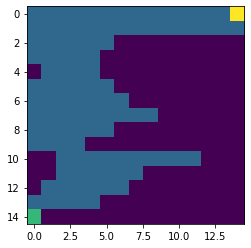

In [228]:
rt = Racetrack(N = 15, track_width_min=3, track_width_max=12, num_starting_points=1, end_points=1)

plt.imshow(rt.plot_map())


In [249]:
Q = np.random.normal(0, 1, (rt.num_states, rt.num_actions))
C = np.zeros((rt.num_states, rt.num_actions))

policy = lambda state_idx: np.argmax(Q[state_idx, ])


episodes = 10000
plotting = episodes//10
gamma = 1
returns = []
eps_max = 0.25
eps_min = 0.05

def eps_greedy(eps):
    def behavior(state_idx, eps=eps, num_actions=9):
        if np.random.uniform() <= eps:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q[state_idx, ])
        return action
    return behavior


<Figure size 432x288 with 0 Axes>

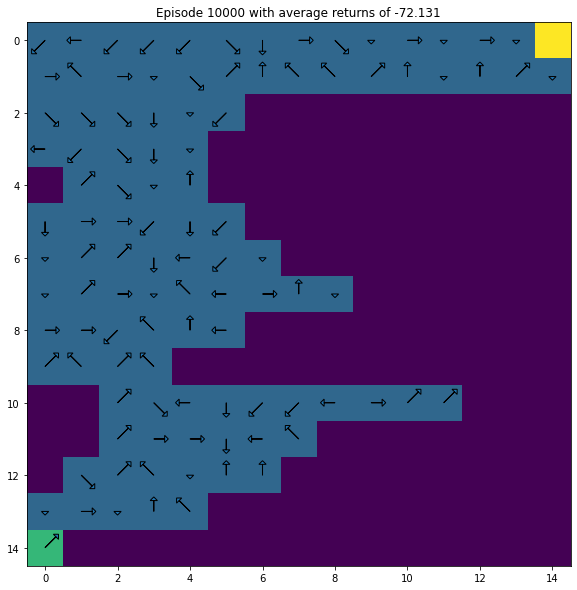

In [250]:
for episode in range(episodes):
    # Initialize episode
    G = 0
    W = 1
    eps = max(eps_max/(episode+1), eps_min)
    behavior = eps_greedy(eps)
    generated_episode = rt.follow_policy(behavior)
    
    for t in range(len(generated_episode)):
        reward = generated_episode[~t][2]
        action = generated_episode[~t][1]
        state = generated_episode[~t][0]
        state_idx = rt.position_to_index(state)
        
        G = gamma * G + reward
        C[state_idx, action] += W
        Q[state_idx, action] += W/C[state_idx, action]*(G - Q[state_idx, action])
        
        if action != policy(state_idx):
            break
        W /= eps/rt.num_actions + (action == policy(state_idx))*(1-eps)
             
    returns.append(G)
    
    if (episode+1) % plotting == 0:
        rt.plot_policy(policy)
        plt.title("Episode %d with returns of %0.3f" % (episode + 1, np.mean(returns[-1001:-1])))
        plt.show()
        
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
rt.plot_policy(policy)
plt.title("Episode %d with average returns of %0.3f" % (episode + 1, np.mean(returns)))
plt.show()

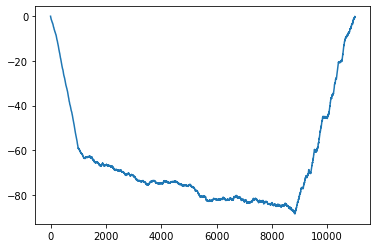

In [254]:
n = 1000
plt.plot(np.convolve(returns, np.ones(n)/n))

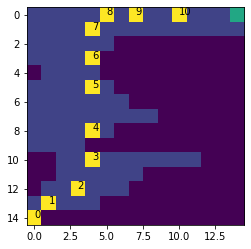

In [252]:
plt.imshow(rt.draw_path(policy))

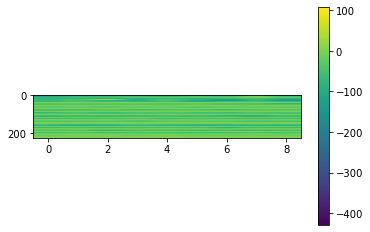

In [245]:
plt.imshow(Q, aspect=4/(25*25))
plt.colorbar()

In [99]:
Q[400, 0]

0.6455494764959568